In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy as sp
import xarray as xr
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import cartopy.crs as ccrs

In [2]:
Orig05 = nc.Dataset('/g/data/tm70/ek4684/hgrids/ocean_hgrid_025deg.nc')
New05 = nc.Dataset('/g/data/tm70/ek4684/ocean_model_grid_generator/ocean_hgrid.nc')
static05 = nc.Dataset('/g/data/tm70/ek4684/hgrids/ocean_static_025deg.nc')

In [3]:
New05

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    history: This grid file was generated via command ocean_grid_generator.py -r 4 --no_south_cap --ensure_nj_even --bipolar_lower_lat 65 --mercator_lower_lat -75 --mercator_upper_lat 65 --match_dy so --shift_equator_to_u_point --south_ocean_lower_lat -81 on 2024-08-12 on platform gadi-login-03.gadi.nci.org.au
    description: This is an orthogonal coordinate grid for the Earth with a nominal resoution of 0.25 degrees along the equator. It consists of; a Mercator grid spanning -74.98774871481207 to 65.02599112266819 degrees; a bipolar northern cap north of 65.02599112266819 degrees; a regular lat-lon grid spanning -74.98774871481207 to -81.0 degrees; 
    source: ocean_grid_generator.py had git hash ccd61f3ee6582fce40b7e668e30b70798cf3124a. To obtain the grid generating code do: git clone https://github.com/ACCESS-NRI/ocean_model_grid_generator ;  git checkout ccd61f3ee6582fce40b7e668e

In [4]:
# Extract the variables
geolon = static05.variables['geolon'][:]
geolat = static05.variables['geolat'][:]
x = Orig05.variables['x'][:]
y = Orig05.variables['y'][:]
dx = Orig05.variables['dx'][:]
dx_new = New05.variables['dx'][:]
dy = Orig05.variables['dy'][:]
dy_new = New05.variables['dy'][:]
area = Orig05.variables['area'][:]
area_new = New05.variables['area'][:]
angle_dx = Orig05.variables['angle_dx'][:]
angle_dx_new = New05.variables['angle_dx'][:]
tlat_new05 = New05.variables['y'][1::2, 1::2]
tlon_new05 = New05.variables['x'][1::2, 1::2]

print(f"geolat_min: {geolat.min()}, max: {geolat.max()}")
print(f"geolon_max: {geolon.min()}, max: {geolon.max()}")

print(f"tlat_new05 min: {tlat_new05.min()}, max: {tlat_new05.max()}")
print(f"tlon_new05 min: {tlon_new05.min()}, max: {tlon_new05.max()}")

geolat_min: -81.0770034790039, max: 89.9404296875
geolon_max: -279.9994812011719, max: 79.99948120117188
tlat_new05 min: -80.93500268880878, max: 89.94100322332858
tlon_new05 min: -279.9994874575885, max: 79.99948745758849


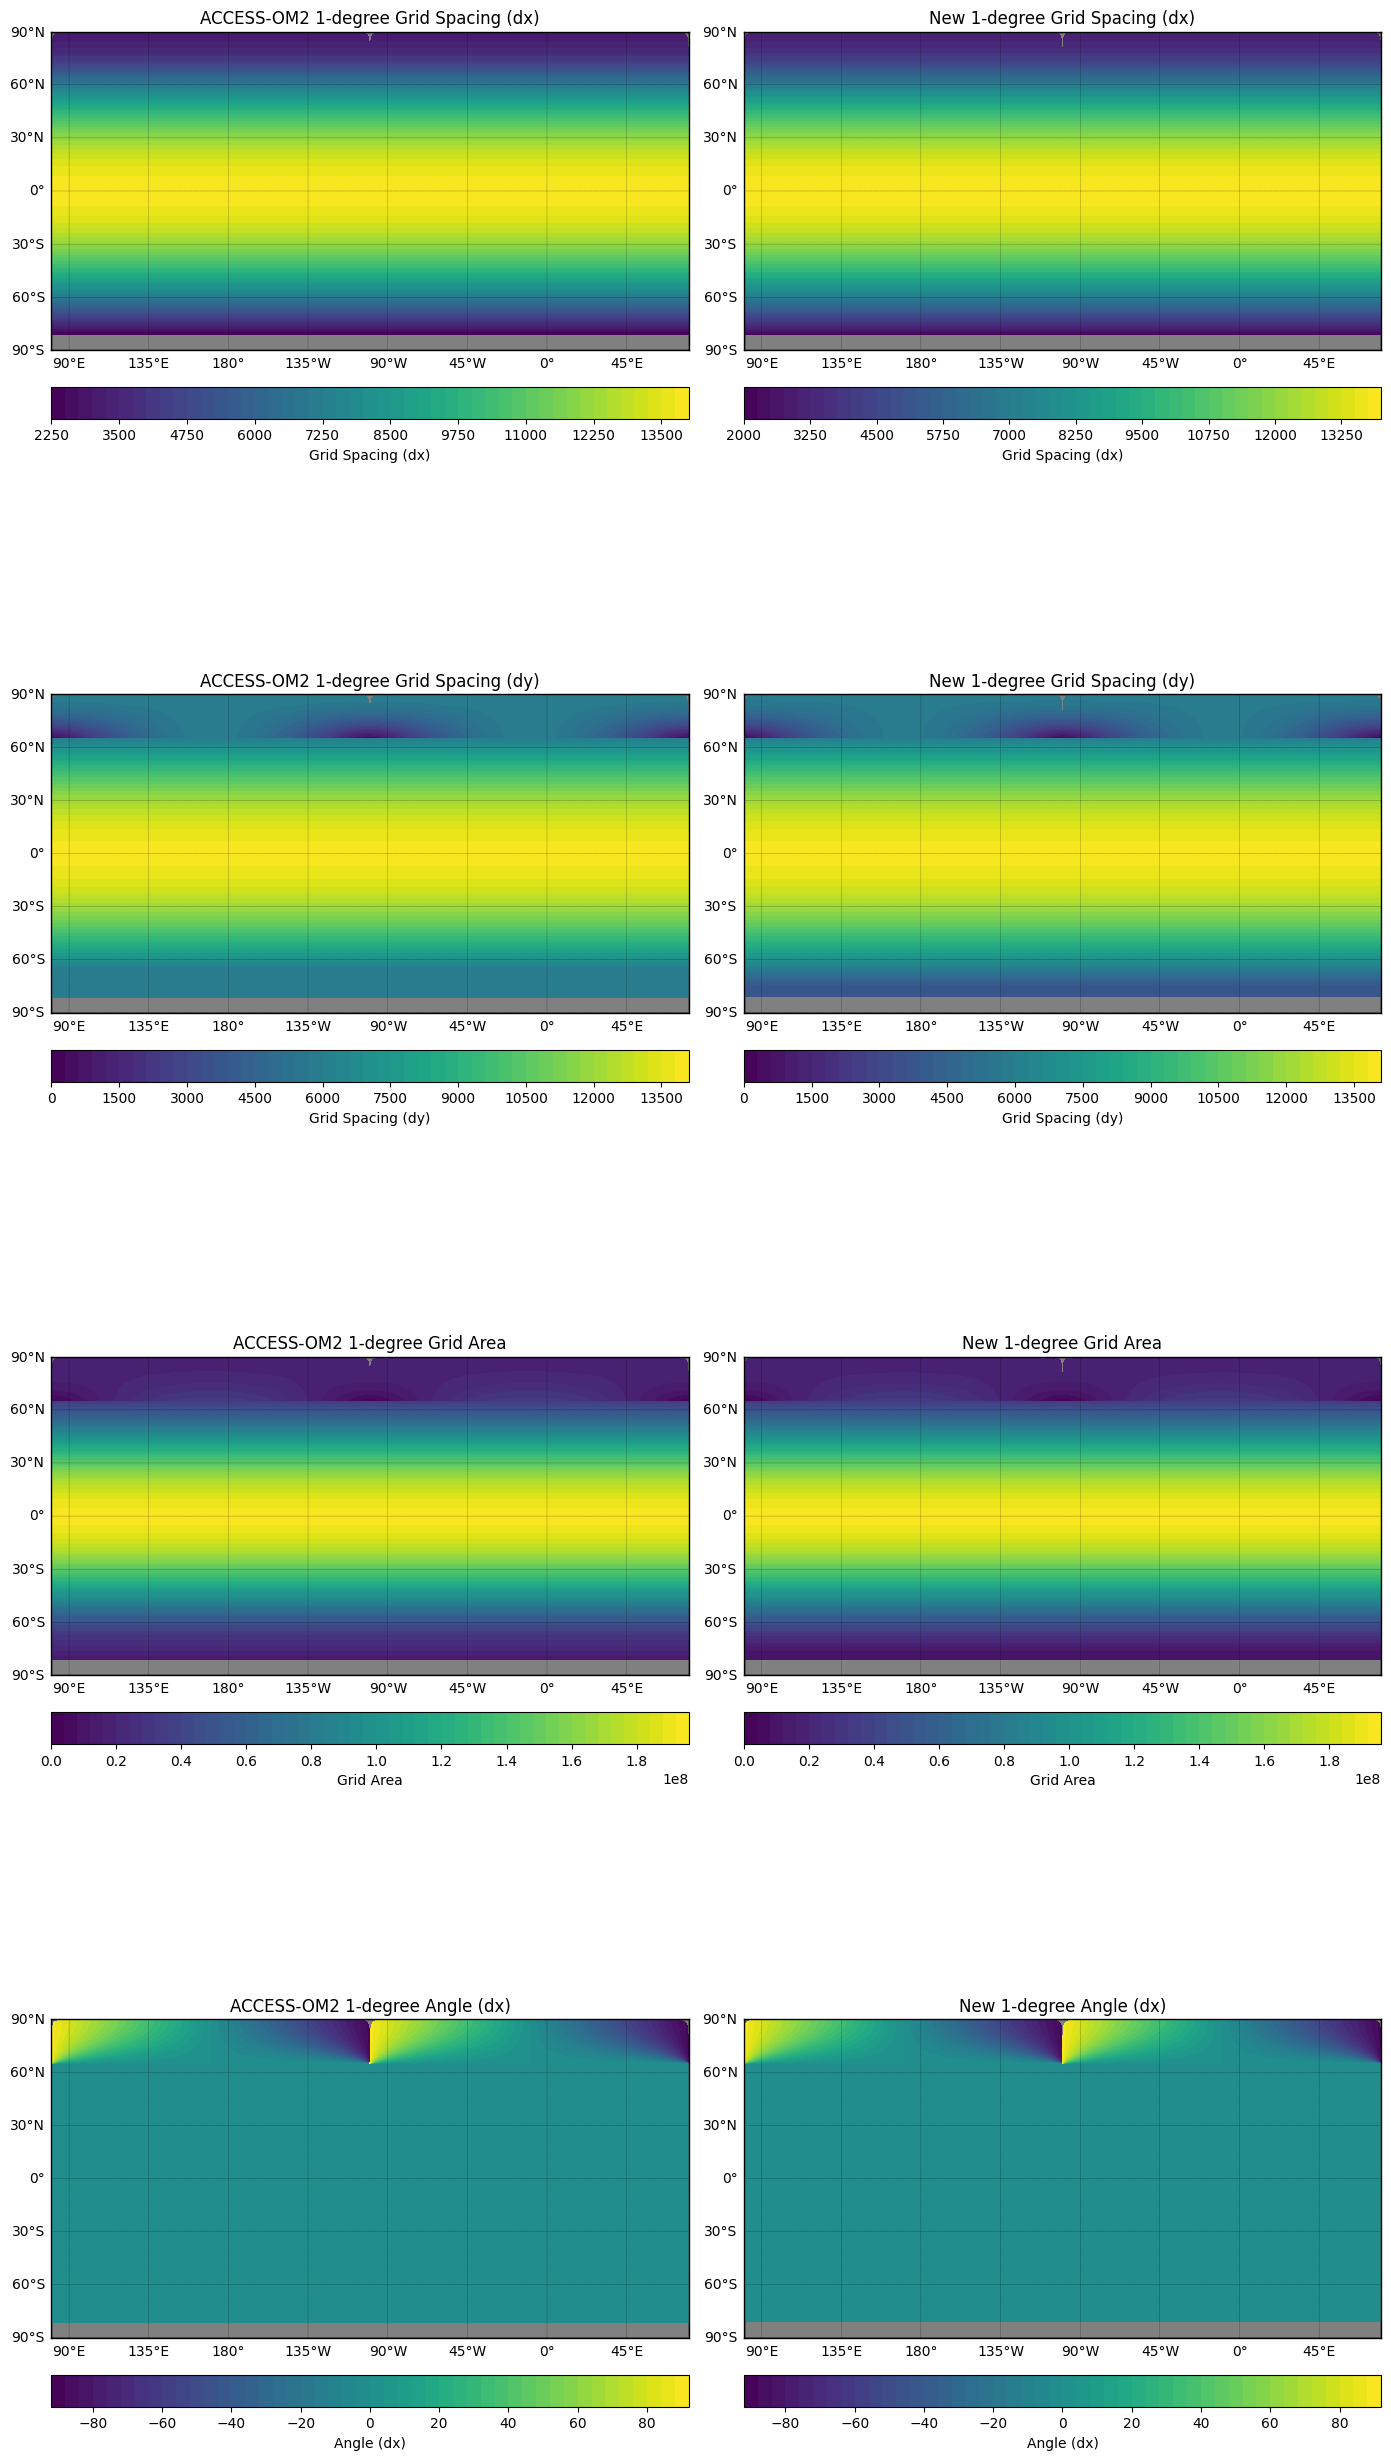

In [6]:
# Define the variables to plot
variables = ['dx', 'dy', 'area', 'angle_dx']
titles = ['Grid Spacing (dx)', 'Grid Spacing (dy)', 'Grid Area', 'Angle (dx)']
orig_data = [dx, dy, area, angle_dx]
new_data = [dx_new, dy_new, area_new, angle_dx_new]

# Create the figure and subplots
fig, axes = plt.subplots(len(variables), 2, figsize=(14, 7 * len(variables)))

for i, var in enumerate(variables):
    # Plot original grid data
    map1 = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-280, urcrnrlon=80, resolution='l', ax=axes[i, 0])
    map1.drawmapboundary(fill_color='gray')
    map1.drawparallels(np.arange(-90., 91., 30.), labels=[True, False, False, False], linewidth=0.25)
    map1.drawmeridians(np.arange(-270, 81, 45), labels=[False, False, False, True], linewidth=0.25)
    X, Y = map1(geolon, geolat)
    p1 = map1.contourf(X, Y, orig_data[i][1::2, 1::2], cmap=plt.cm.viridis,levels=50)
    axes[i, 0].set_title(f'ACCESS-OM2 1-degree {titles[i]}')
    
    # Plot new grid data
    map2 = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-280, urcrnrlon=80, resolution='l', ax=axes[i, 1])
    map2.drawmapboundary(fill_color='gray')
    map2.drawparallels(np.arange(-90., 91., 30.), labels=[True, False, False, False], linewidth=0.25)
    map2.drawmeridians(np.arange(-270, 81, 45), labels=[False, False, False, True], linewidth=0.25)
    X_new, Y_new = map2(tlon_new05, tlat_new05)
    p2 = map2.contourf(X_new, Y_new, new_data[i][1::2, 1::2], cmap=plt.cm.viridis, levels=50)
    axes[i, 1].set_title(f'New 1-degree {titles[i]}')
    # Add individual colorbars for each subplot
    cbar1 = fig.colorbar(p1, ax=axes[i, 0], orientation='horizontal', fraction=0.05, pad=0.05)
    cbar1.set_label(titles[i])

    cbar2 = fig.colorbar(p2, ax=axes[i, 1], orientation='horizontal', fraction=0.05, pad=0.05)
    cbar2.set_label(titles[i])    

plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.show()

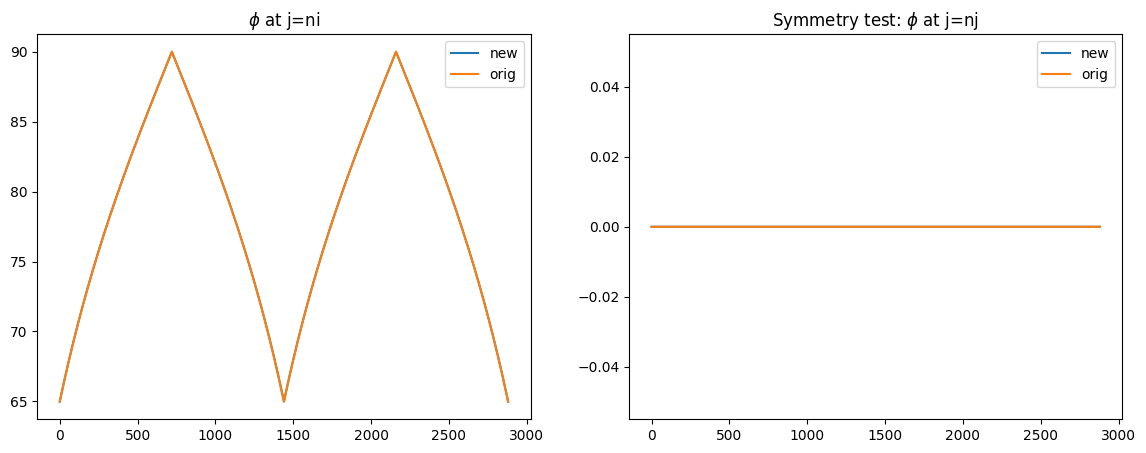

In [9]:
# Y top edge
plt.figure(figsize=(14,5));
plt.subplot(121)
plt.plot( New05['y'][-1,:], label='new' );
plt.plot( Orig05['y'][-1,:], label='orig' );
plt.title('$\phi$ at j=ni');
plt.legend();
# Y symmetry
plt.subplot(122)
plt.plot( New05['y'][-2,:] - New05['y'][-2,::-1], label='new' );
plt.plot( Orig05['y'][-1,:] - Orig05['y'][-1,::-1], label='orig' );
plt.title('Symmetry test: $\phi$ at j=nj');
plt.legend();

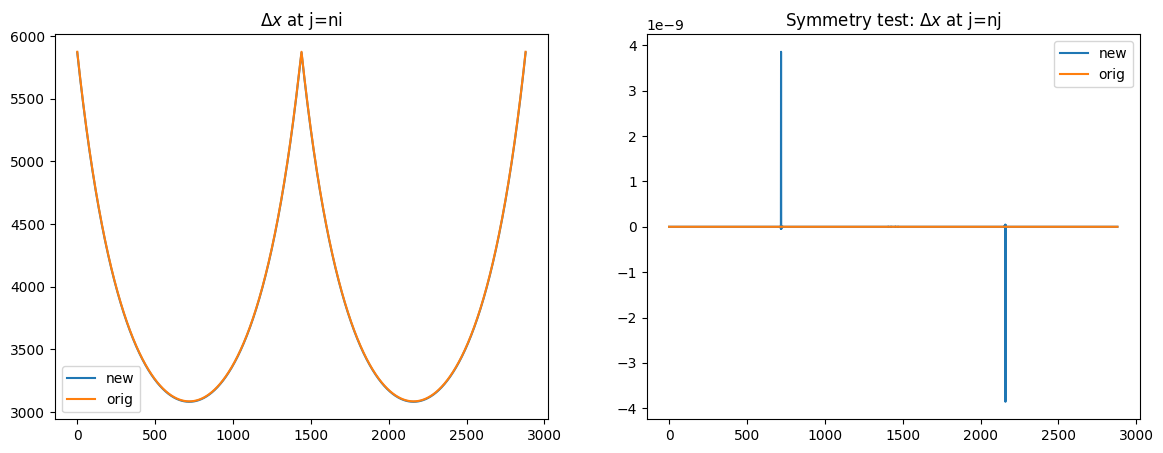

In [10]:
# DX top edge
plt.figure(figsize=(14,5));
plt.subplot(121)
plt.plot( New05['dx'][-1,:], label='new' );
plt.plot( Orig05['dx'][-1,:], label='orig' );
plt.title('$\Delta x$ at j=ni');
plt.legend();
# DX symmetry
plt.subplot(122)
plt.plot( New05['dx'][-2,:] - New05['dx'][-2,::-1], label='new' );
plt.plot( Orig05['dx'][-1,:] - Orig05['dx'][-1,::-1], label='orig' );
plt.title('Symmetry test: $\Delta x$ at j=nj');
plt.legend();

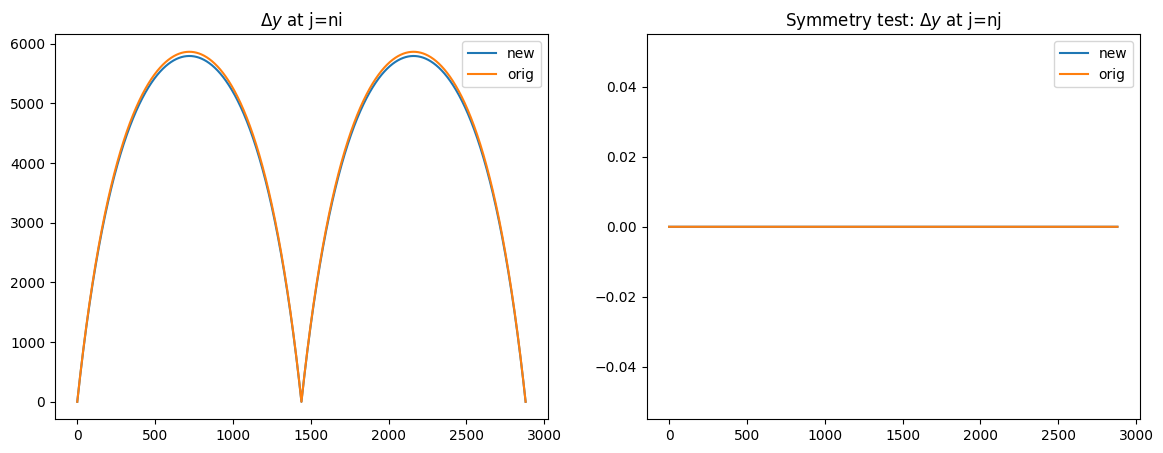

In [11]:
# DX top edge
plt.figure(figsize=(14,5));
plt.subplot(121)
plt.plot( New05['dy'][-1,:], label='new' );
plt.plot( Orig05['dy'][-1,:], label='orig' );
plt.title('$\Delta y$ at j=ni');
plt.legend();
# DX symmetry
plt.subplot(122)
plt.plot( New05['dy'][-1,:] - New05['dy'][-1,::-1], label='new' );
plt.plot( Orig05['dy'][-1,:] - Orig05['dy'][-1,::-1], label='orig' );
plt.title('Symmetry test: $\Delta y$ at j=nj');
plt.legend();

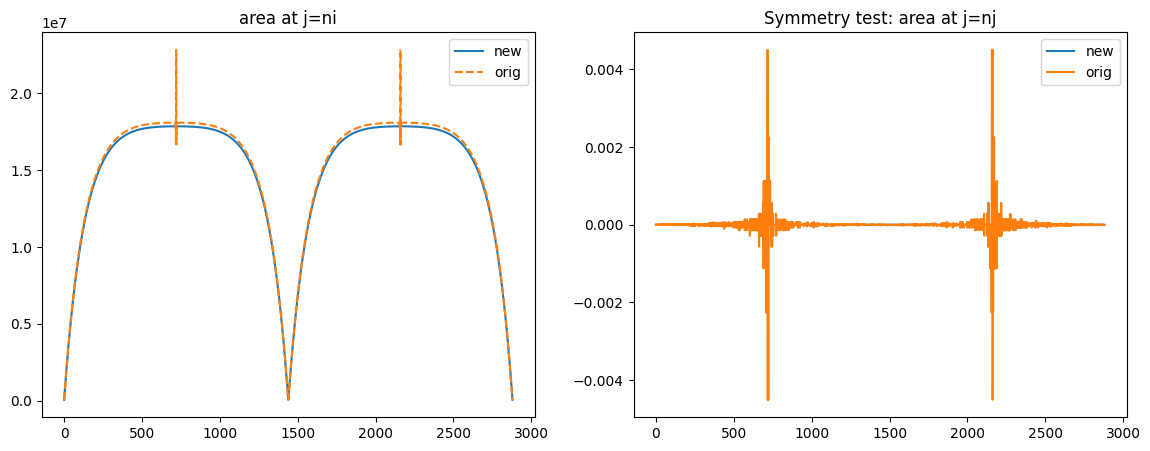

In [26]:
# AREA top edge
plt.figure(figsize=(14,5));
plt.subplot(121)
plt.plot(New05['area'][-1,:], label='new' , linestyle='-');
plt.plot(Orig05['area'][-1,:], label='orig',linestyle='--');
plt.title('area at j=ni');
plt.legend();
# AREA symmetry
plt.subplot(122)
plt.plot( New05['area'][-1,:] - New05['area'][-1,::-1], label='new' );
plt.plot( Orig05['area'][-1,:] - Orig05['area'][-1,::-1], label='orig' );
plt.title('Symmetry test: area at j=nj');
plt.legend();

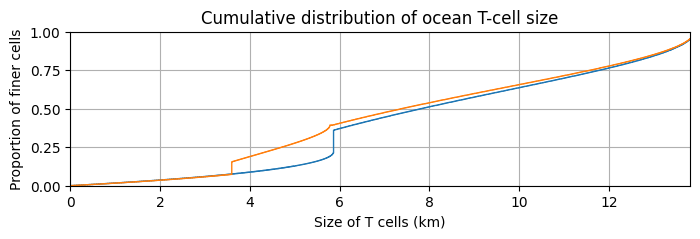

In [17]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.hist(np.ma.ravel(dy/1000), bins=1000, density=True, histtype='step',
                           cumulative=True,label='Access OM2 grid');
ax.hist(np.ma.ravel(dy_new/1000), bins=1000, density=True, histtype='step',
                           cumulative=True,label='New grid');
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
plt.gca().set_xlim(0,13.8)
plt.yticks([0, .25, .5, .75, 1])
plt.grid()
plt.xlabel('Size of T cells (km)')
plt.ylabel('Proportion of finer cells');
plt.title('Cumulative distribution of ocean T-cell size');
plt.savefig('/g/data/tm70/ek4684/hgrids/grid_scatter.png',dpi=300, bbox_inches="tight")

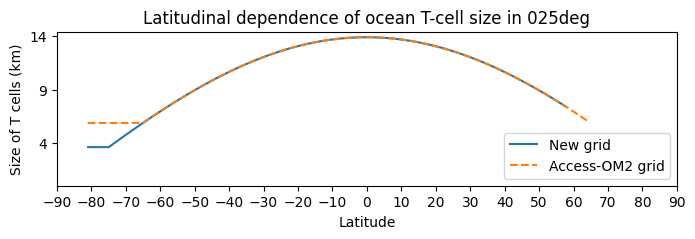

In [20]:
fig, ax = plt.subplots(figsize=(8, 2))
plt.plot(tlat_new05[:840,1], dy_new[1:1680:2,1]/1000, label='New grid', linestyle='-')
plt.plot(y[1:1680:2,1], dy[1:1680:2,1]/1000, label='Access-OM2 grid', linestyle='--')
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(-90,90)
plt.xticks(range(-90,91,10))
plt.yticks(range(4,15,5))
plt.ylabel('Size of T cells (km)')
plt.xlabel('Latitude');
plt.title('Latitudinal dependence of ocean T-cell size in 025deg');
ax.legend(loc='lower right')
plt.savefig('/g/data/tm70/ek4684/hgrids/grid_scatter.png',dpi=300, bbox_inches="tight")

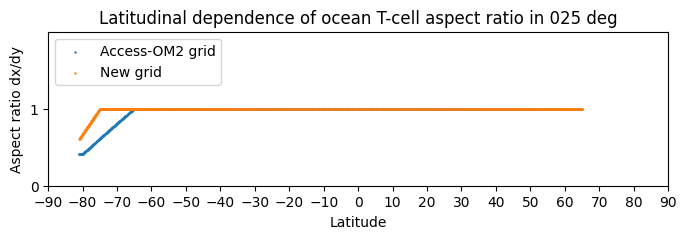

In [21]:
fig, ax = plt.subplots(figsize=(8, 2))
plt.scatter(y[1::2,1],(dx[1::2,1]/dy[1::2,1]),s=.5, label='Access-OM2 grid')
plt.scatter(tlat_new05[:,1],(dx_new[1::2,1]/dy_new[1::2,1]),s=.5, label='New grid')
plt.gca().set_ylim(0,2)
plt.gca().set_xlim(-90,90)
plt.xticks(range(-90,91,10))
plt.yticks(range(0,2))
plt.ylabel('Aspect ratio dx/dy')
plt.xlabel('Latitude');
plt.title('Latitudinal dependence of ocean T-cell aspect ratio in 025 deg');
ax.legend(loc='upper left')
plt.savefig('/g/data/tm70/ek4684/hgrids/grid_scatter.png',dpi=300, bbox_inches="tight")

In [22]:
#To make 1 deg grid
#./make_hgrid --verbose --grid_type tripolar_grid --nxbnds 2 --nybnds 7 --xbnd -280,80 --ybnd -78,-30,-10,10,30,65,90 --dlon 1,1 --dlat 0.24675325,1,0.33333333,0.333333333,1.00000001,0.4583335,0.4507575 --center c_cell --rotate_poly

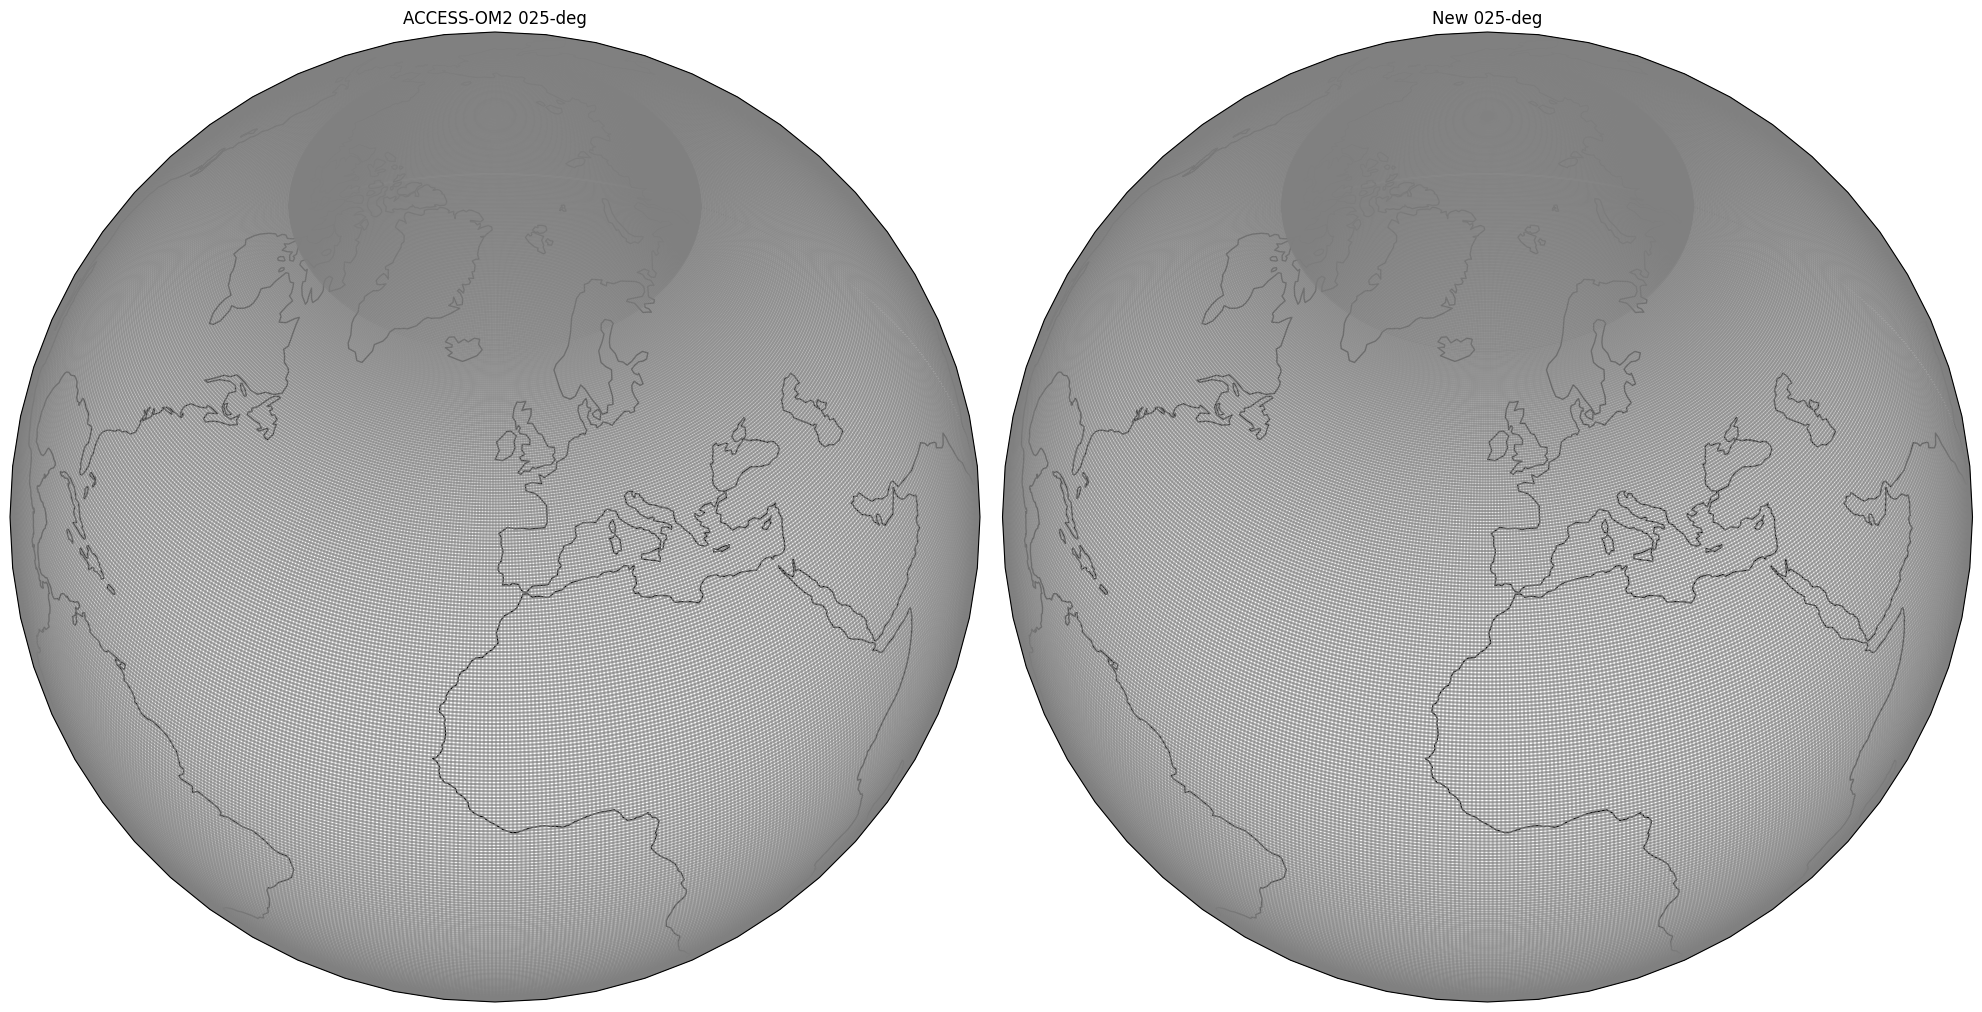

<Figure size 640x480 with 0 Axes>

In [25]:
import cartopy.crs as ccrs

# Define the subset of grid data
subset_x = Orig05.variables['x'][1::4, 1::4]
subset_y = Orig05.variables['y'][1::4, 1::4]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.Orthographic(-10, 45)})

# Plot on the first subplot
ax1 = axes[0]
ax1.set_global()
ax1.coastlines()
ax1.plot(subset_x, subset_y, transform=ccrs.PlateCarree(), color='grey', alpha=0.5)
ax1.plot(subset_x.transpose(), subset_y.transpose(), transform=ccrs.PlateCarree(), color='grey', alpha=0.7)
ax1.set_title('ACCESS-OM2 025-deg')

subset_x = New05.variables['x'][1::4, 1::4]
subset_y = New05.variables['y'][1::4, 1::4]

# Plot on the second subplot
ax2 = axes[1]
ax2.set_global()
ax2.coastlines()
ax2.plot(subset_x, subset_y, transform=ccrs.PlateCarree(), color='grey', alpha=0.5)
ax2.plot(subset_x.transpose(), subset_y.transpose(), transform=ccrs.PlateCarree(), color='grey', alpha=0.7)
ax2.set_title('New 025-deg')

# Adjust layout
plt.tight_layout()
plt.show()
plt.savefig('/g/data/tm70/ek4684/hgrids/grid_tripole.png')